C:\Users\qz199\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\qz199\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\qz199\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([51])) that is different to the input size (torch.Size(

Epoch 1, Train Loss: 5.5283, Test Loss: 0.1181
Epoch 2, Train Loss: 0.0513, Test Loss: 0.0172
Epoch 3, Train Loss: 0.0144, Test Loss: 0.0087
Epoch 4, Train Loss: 0.0118, Test Loss: 0.0035
Epoch 5, Train Loss: 0.0088, Test Loss: 0.0021
Epoch 6, Train Loss: 0.0077, Test Loss: 0.0021
Epoch 7, Train Loss: 0.0076, Test Loss: 0.0025
Epoch 8, Train Loss: 0.0076, Test Loss: 0.0019
Epoch 9, Train Loss: 0.0086, Test Loss: 0.0043
Epoch 10, Train Loss: 0.0074, Test Loss: 0.0023
Epoch 11, Train Loss: 0.0067, Test Loss: 0.0034
Epoch 12, Train Loss: 0.0070, Test Loss: 0.0021
Epoch 13, Train Loss: 0.0066, Test Loss: 0.0019
Epoch 14, Train Loss: 0.0066, Test Loss: 0.0021
Epoch 15, Train Loss: 0.0074, Test Loss: 0.0057
Epoch 16, Train Loss: 0.0077, Test Loss: 0.0028
Epoch 17, Train Loss: 0.0070, Test Loss: 0.0020
Epoch 18, Train Loss: 0.0059, Test Loss: 0.0029
Epoch 19, Train Loss: 0.0059, Test Loss: 0.0044
Epoch 20, Train Loss: 0.0064, Test Loss: 0.0022
Epoch 21, Train Loss: 0.0074, Test Loss: 0.0083
E

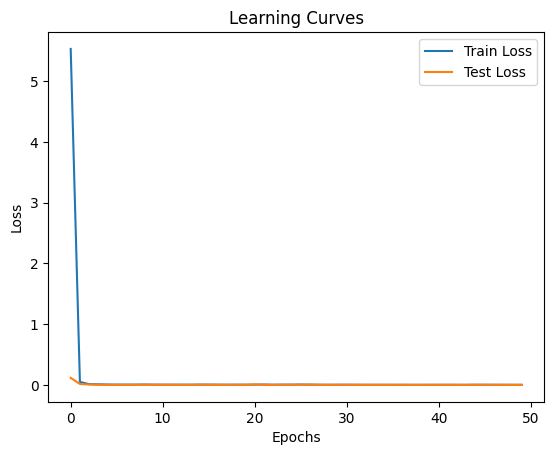

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import pandas as pd

data = pd.read_excel('return.xlsx')

# Dropping the date column and preparing features and target
X = data.drop(columns=['Equity', 'Return'])
y = data['Return']

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Creating dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Defining a simple Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.linear_in = nn.Linear(input_dim, dim_feedforward)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(dim_feedforward, output_dim)

    def forward(self, src):
        src = self.linear_in(src)
        output = self.transformer_encoder(src)
        output = self.linear_out(output)
        return output

# Model parameters
input_dim = X_train.shape[1]
num_heads = 2
dim_feedforward = 512
num_layers = 2
output_dim = 1

# Model, loss, and optimizer
model = TransformerModel(input_dim, num_heads, dim_feedforward, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

import torch

def train(model, criterion, optimizer, train_loader, test_loader, epochs):
    model.train()
    train_losses = []
    test_losses = []
    y_predicts = []  # Store predictions for each epoch
    
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Validation loss and predictions
        model.eval()
        total_loss_test = 0
        all_predictions = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                total_loss_test += loss.item()
                all_predictions.extend(output.detach().cpu().numpy())
                
        test_losses.append(total_loss_test / len(test_loader))
        y_predicts.append(all_predictions)  # Store predictions for this epoch
        
        model.train()
        
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
        
    return train_losses, test_losses, y_predicts


# Training the model
epochs = 50
train_losses, test_losses,another_value = train(model, criterion, optimizer, train_loader, test_loader, epochs)

# Plotting the learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [ ]:
y_test, y_predictor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Using previously prepared training data

# Training random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Ranking feature by importance
feature_importances = rf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

# Visualizing importance
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances[sorted_idx], y=X.columns[sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [ ]:
# Calculating correlation between features
correlation_matrix = X.corr()

# Seaborn heatmap
plt.figure(figsize=(8, 6))  
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Last Encoder Layer Self-Attention Heatmap')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Loading data
data = pd.read_excel('AAPL_with_return.xlsx')
X = data.drop(columns=['AAPL UW Equity', 'Return'])
y = data['Return']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Using R-squared as benchmark, random forest model as example
base_score = model.score(X_test, y_test)
print(f"Base R² score: {base_score:.3f}")

# Scoring and ranking
results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Visualize
feature_names = X.columns
forest_importances = pd.Series(results.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=results.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
model = LinearRegression()
model.fit(X_train, y_train)
base_score = model.score(X_test, y_test)

# Saving R-squared changes for each feature
r_squared_changes = {}

for feature in X.columns:
    X_train_temp = X_train.drop(columns=[feature])
    X_test_temp = X_test.drop(columns=[feature])
    
    model_temp = LinearRegression()
    model_temp.fit(X_train_temp, y_train)
    score_temp = model_temp.score(X_test_temp, y_test)
    
    # Calculate difference in R-squared after feature is removed 
    r_squared_changes[feature] = base_score - score_temp

# Printing
for feature, change in r_squared_changes.items():
    print(f"{feature}: R^2 change = {change:.3f}")